# **Sentiment Analysis on IMDB Movie Reviews**

### **Project Overview**

In this project, we aim to perform sentiment analysis on movie reviews from the IMDB dataset. Sentiment analysis is a common task in natural language processing (NLP) where the goal is to classify the sentiment expressed in a piece of text. Specifically, we want to determine whether a given movie review expresses a positive or negative sentiment.

In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [ ]:
import tensorflow_datasets as tfds

# The dataset contains 50,000 movie reviews with their respective sentiment labels (positive/negative)
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# Split the dataset into training and testing sets
train_data, test_data = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.Y2ZC11_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.Y2ZC11_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.Y2ZC11_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# Display the first few reviews and their corresponding labels
for review, label in train_data.take(5):
    print(f'Review: {review.numpy()}')
    print(f'Label: {"Positive" if label.numpy() == 1 else "Negative"}')
    print('---')

Review: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label: Negative
---
Review: b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film w

In [ ]:
# Calculate the distribution of labels in the training dataset
positive_reviews = 0
negative_reviews = 0

for _, label in train_data:
    if label.numpy() == 1:
        positive_reviews += 1
    else:
        negative_reviews += 1

print(f'Number of Positive Reviews: {positive_reviews}')
print(f'Number of Negative Reviews: {negative_reviews}')
print(f'Total Reviews: {positive_reviews + negative_reviews}')


Number of Positive Reviews: 12500
Number of Negative Reviews: 12500
Total Reviews: 25000


In [ ]:
# Display the length of the first few reviews before padding
for review, _ in train_data.take(5):
    print(f'Review length (before padding): {len(review.numpy())}')

Review length (before padding): 709
Review length (before padding): 617
Review length (before padding): 787
Review length (before padding): 464
Review length (before padding): 413


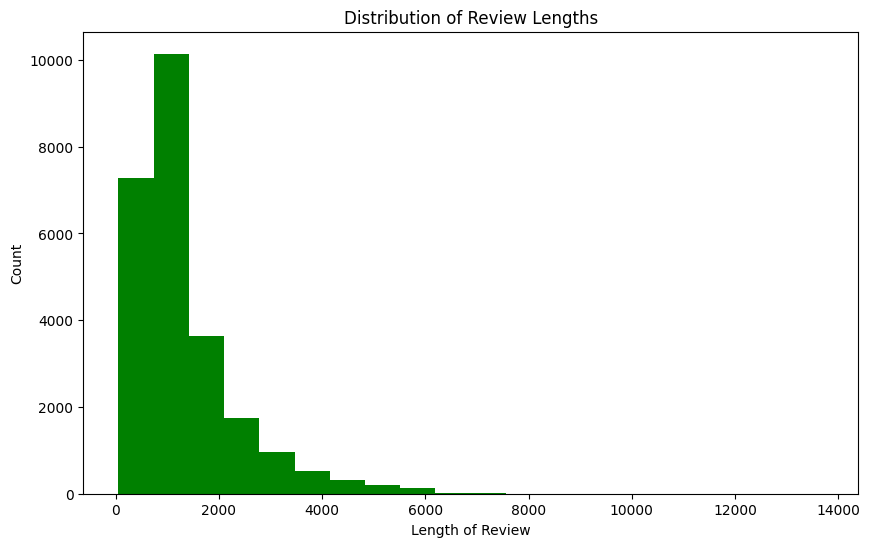

In [ ]:
import matplotlib.pyplot as plt

review_lengths = [len(review.numpy()) for review, _ in train_data]

plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=20, color='green')
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Review')
plt.ylabel('Count')
plt.show()


In [ ]:
# Define constants
BUFFER_SIZE = 10000
BATCH_SIZE = 64
VOCAB_SIZE = 10000

# Build the tokenizer using the training data
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (review.numpy() for review, label in train_data), target_vocab_size=VOCAB_SIZE)

def encode_review(review, label):
    encoded_review = tokenizer.encode(review.numpy())
    encoded_review = [min(token, VOCAB_SIZE - 1) for token in encoded_review]
    return encoded_review, label

def encode_map_fn(review, label):
    encoded_review, label = tf.py_function(encode_review, inp=[review, label], Tout=(tf.int64, tf.int64))
    encoded_review.set_shape([None])
    label.set_shape([])
    return encoded_review, label

# Apply the encoding function to the training and testing data
train_data = train_data.map(encode_map_fn)
test_data = test_data.map(encode_map_fn)

# Batch and pad the datasets to ensure each batch has the same shape
train_data = train_data.padded_batch(BATCH_SIZE, padded_shapes=([None], []))
test_data = test_data.padded_batch(BATCH_SIZE, padded_shapes=([None], []))

In [ ]:
# Create the model using Sequential API
model = tf.keras.Sequential([
    tf.keras.Input(shape=(100,)),
    # Embedding layer converts integer sequences to dense vector representations
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64,),

    # Bidirectional LSTM layers to capture information from both directions
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

    # Fully connected dense layer with ReLU activation
    tf.keras.layers.Dense(64, activation='relu'),

    # Output layer with sigmoid activation for binary classification
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Print the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 751,489 (2.87 MB)

 Trainable params: 751,489 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model for 5 epochs and validate on the test data
history = model.fit(train_data, epochs=5, validation_data=test_data)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 163s 402ms/step - accuracy: 0.6551 - loss: 0.5960 - val_accuracy: 0.7449 - val_loss: 0.5272
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 117s 299ms/step - accuracy: 0.8457 - loss: 0.3696 - val_accuracy: 0.7998 - val_loss: 0.4514
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 143s 301ms/step - accuracy: 0.8761 - loss: 0.3089 - val_accuracy: 0.8206 - val_loss: 0.4685
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 140s 296ms/step - accuracy: 0.8611 - loss: 0.3307 - val_accuracy: 0.8137 - val_loss: 0.4617
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 117s 300ms/step - accuracy: 0.8940 - loss: 0.2750 - val_accuracy: 0.8491 - val_loss: 0.4008


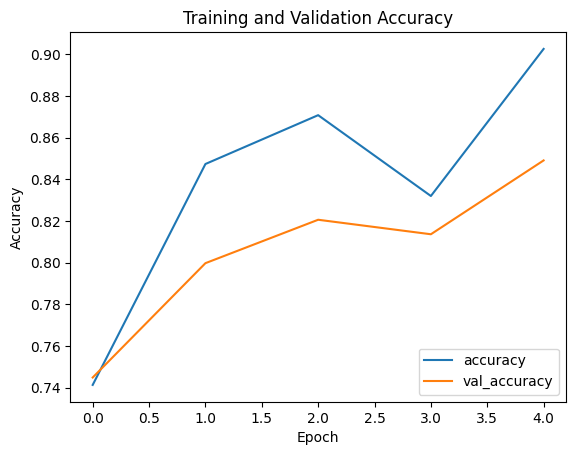

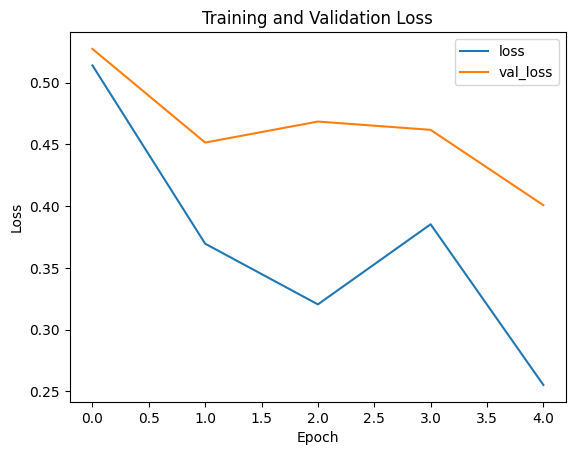

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluate the model on the test data to get the accuracy
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 113ms/step - accuracy: 0.8487 - loss: 0.4116
Test Accuracy: 84.91%


In [ ]:
# Save the model in the recommended Keras format
model.save('movie_review.keras')

In [ ]:
from tensorflow.keras.models import load_model

# Load the model from the .keras file
model = load_model('movie_review.keras')

In [ ]:
y_pred = model.predict(test_data)

y_pred_classes = (y_pred > 0.5).astype("int32")

391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 108ms/step


In [ ]:
# Extract true labels from test_data
y_true = []
for _, label in test_data:
    y_true.extend(label.numpy())

import numpy as np
# Convert to numpy array for compatibility with sklearn
y_true = np.array(y_true)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes)

# Print out the metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")


Precision: 0.82
Recall: 0.90
F1-score: 0.86


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm

array([[10019,  2481],
       [ 1291, 11209]])

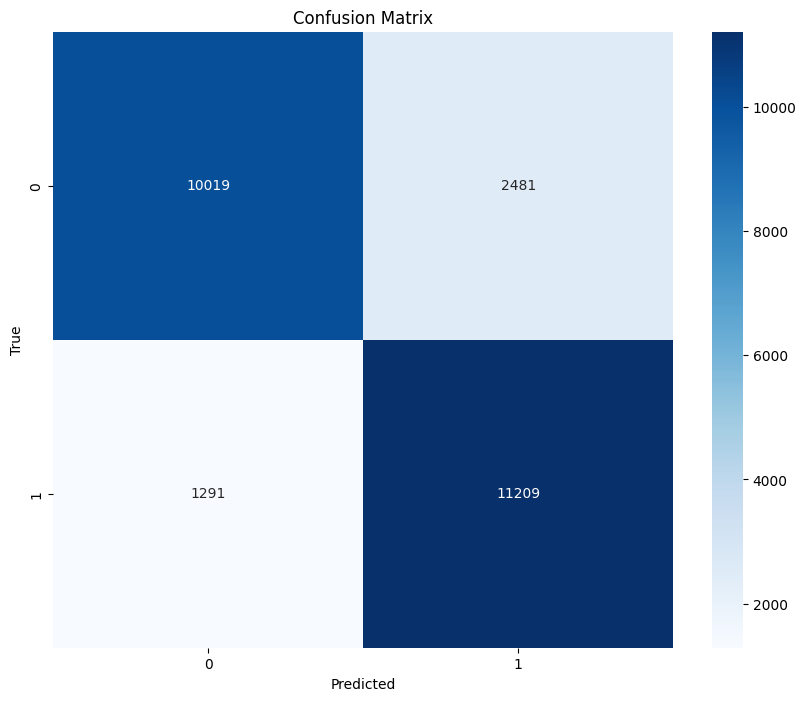

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **Conclusion**

### **Model Performance**

In this project, we successfully built and trained a deep learning model to perform sentiment analysis on the IMDB movie reviews dataset. The model achieved a test accuracy of 84.91%, which indicates a strong ability to correctly classify movie reviews as either positive or negative.

### **Generalization to Unseen Data**

The model demonstrates solid performance on the test data, suggesting that it has learned meaningful patterns from the training data that generalize well to unseen reviews. However, there are still opportunities for improvement, especially in fine-tuning the model to enhance precision without compromising recall.

### **Potential Next Steps**

While the model generalizes well to unseen data, further improvements could be achieved through hyperparameter tuning, exploring alternative architectures like GRUs or attention mechanisms, applying data augmentation techniques to enhance diversity, and incorporating regularization methods to prevent overfitting.

### **Final Thoughts**

This project showcases the potential of deep learning models for text classification tasks such as sentiment analysis. With further refinement, the model can be adapted and improved to achieve even better performance, making it a valuable tool for automatically assessing the sentiment expressed in text data.